# Usage examples for `dynsys`

This is a bare-bones dynamical systems library. I'll be continually adding functionality, but it isn't intended to replace `scipy` for numerical computation by any means---it's really just a way for me to have fun.

### Basic example

Let's just look at a plot of the harmonic oscillator. Recall that an idealized harmonic oscillator is governed by Hooke's law:

\begin{equation}
\ddot{x} = -kx
\end{equation}

where $k > 0$ is the spring constant and we've normalized mass to be $m \equiv 1$. It's easy to find the analytical solution of this equation using the *ansatz* $x(t) = e^{bt}$: substitute and differentiate twice to find $x(t) \propto \Re e^{i \sqrt{k}t + \phi} = \cos(\sqrt{k}t + \phi)$, where $\phi$ is the phase angle. 

Recall also, for the purposes of simulation and analysis, that every $n$-th order ODE can be written as $n$ first-order ODEs. Here, we can write the harmonic oscillator as

\begin{equation}
\begin{aligned}
\dot{x} &= v\\
\dot{v} &= -kx
\end{aligned}
\end{equation}

The integrators in `dynsys`, along with every other numerical integrator, take the $n$ first-order formulation instead of the $n$-th order formulation.

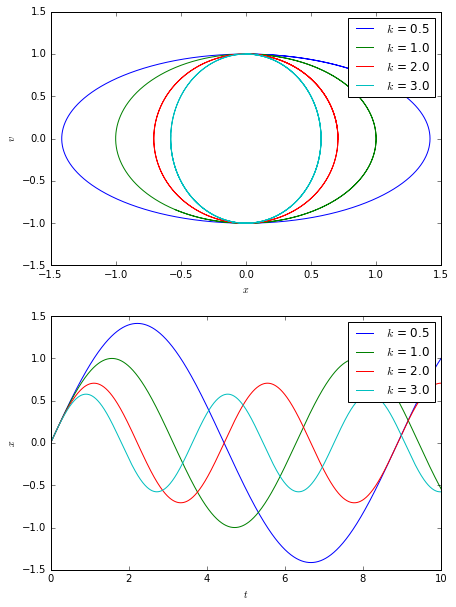

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from euler import euler_forward

ks = [0.5, 1., 2., 3.]
x0 = [0., 1.]  #x0 = 0, v0 = 1
t0 = 0.
T = 10.
dt = 0.00005

def f(x, t, k=1.):
    return np.asarray( [x[1], -1. * k * x[0]] )

fig, axes = plt.subplots(2, 1, figsize=(7, 10))

for k in ks:
    x, time = euler_forward(f, t0, T, dt, x0, fargs={'k' : k})
    axes[0].plot(x[:, 0], x[:, 1], label='$k$ = {}'.format(k))
    axes[1].plot(time, x[:, 0], label='$k$ = {}'.format(k))
    
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$v$')
axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$x$')
axes[0].legend()
axes[1].legend()

plt.show()

Right now I have only Euler methods implemented, so keep in mind when choosing the step size $\Delta t$ that global error is $\mathcal{O}(\Delta t)$.

We could also examine the effect of friction on the harmonic oscillator. The oscillator with friction is governed by the nondimensionalized equation 

\begin{equation}
\ddot{x} + b \dot{x} + x = 0,
\end{equation}

or, in first-order form, 

\begin{equation}
\begin{aligned}
\dot{x} &= v \\
\dot{v} &= -bv -x.
\end{aligned}
\end{equation}

Let us examine the phase space of the oscillator as we vary the parameter $b$.

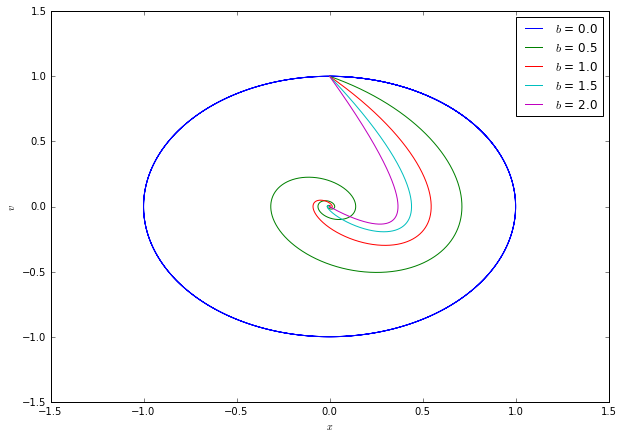

In [2]:
bs = np.linspace(0., 2., 5)
x0 = [0., 1.]  #x0 = 0, v0 = 1
t0 = 0.
T = 20.
dt = 0.00005

def f(x, t, b=0.):
    return np.asarray( [x[1],
                        -1. * b * x[1] -1. * x[0]] )

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for b in bs:
    x, time = euler_forward(f, t0, T, dt, x0, fargs={'b' : b})
    ax.plot(x[:, 0], x[:, 1], label='$b$ = {}'.format(round(b, 2)))
    
ax.set_xlabel('$x$')
ax.set_ylabel('$v$')
ax.legend()

plt.show()

We see--we'd better!--that the introduction of friction means that oscillatory motion is eventually damped as the oscillator settles into the rest point at the origin. Note that there exists a value of $b$ above which the oscillator effectively acts as a first-order ODE.

### The pendulum

We're all familiar with the small-angle approximation to the pendulum: since, for $0 \leq \theta \ll 1$ we have that $\sin \theta \simeq \theta$, we can approximate the pendulum's equation of motion, given by 

\begin{equation}
\ddot{\theta} + \frac{g}{\ell} \sin \theta
\end{equation}

can be approximated by the harmonic oscillator, which is obviously completely solvable. Since we have numerical integration, we don't have to settle. Let's see what the phase space of the pendulum looks like for a variety of initial conditions!

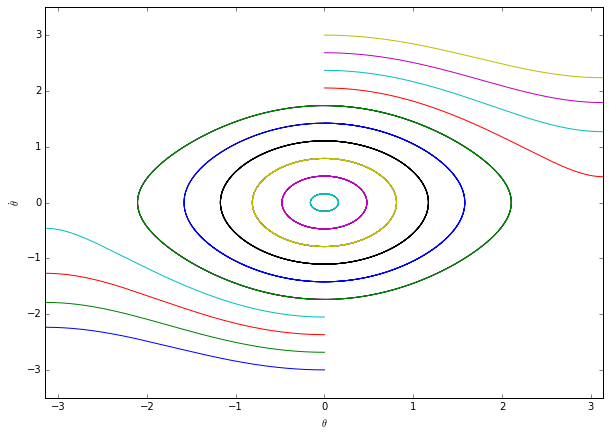

In [3]:
thetadots = np.linspace(-3., 3., 20)
t0 = 0.
T = 20.
dt = 0.00005

def f(x, t):
    return np.asarray( [x[1],
                        -1. * np.sin(x[0])] )

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for thetadot in thetadots:
    x, time = euler_forward(f, t0, T, dt, [0., thetadot])
    ax.plot( x[:, 0], x[:, 1], label=round(thetadot, 2) )
    
ax.set_xlabel('$\\theta$')
ax.set_ylabel('$\dot{\\theta}$')
#ax.legend()
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-3.5, 3.5)

plt.show()

### Stochastic models

In addition to ODEs, we can also numerically integrate stochastic differential equations (SDEs). Consider, for example, the canonical stock price model of geometric Brownian motion expressed in the Ito formulation:

\begin{equation}
dX_t = \mu X_t dt + \sigma X_t dW_t
\end{equation}

where $dW_t$ is a differential Wiener process; $dW_t \sim \mathcal{N}(0, \sqrt{dt})$ with independent increments.

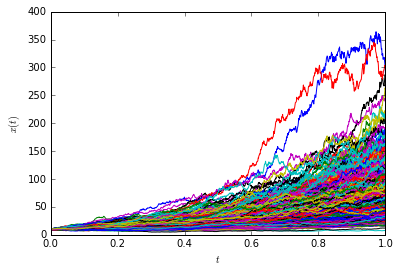

In [4]:
from euler import euler_ito_sde
from dynplot import quickplot

def mu(x, t):
    return 2. * x  # so $\mu = 2$ above

def sigma(x, t):
    return 0.5 * x  # so $\sigma = 0.5$ above

t0 = 0.
T = 1.
dt = 0.001
x0 = 10.  # stock price starts at 10

paths, time = euler_ito_sde(mu, sigma, t0, T, dt, x0, reruns=1000)

fig, ax = plt.subplots()
ax.set_xlabel('$t$')
ax.set_ylabel('$x(t)$')

quickplot(paths, time, ax=ax)

For now, `quickplot` supports only one-dimensional paths. 

We can also model a more sophisticated system of SDEs with `euler_ito_sde`. Here's an example of coupled nonlinear Brownian motion:

\begin{equation}
\begin{aligned}
dX_t &= -\mu(X_t - Y_t)^2dt + \sigma X_t Y_t dW_t^{(X)} \\
dY_t &= -\mu(X_t + Y_t)^2dt + \sigma(X_t - Y_t) dW_t^{(Y)} \\
\text{cov}&(dW_t^{(X)}, dW_t^{(Y)}) = I dt
\end{aligned}
\end{equation}

Note that `euler_ito_sde` does not support correlated noise; models of that are coming soon!

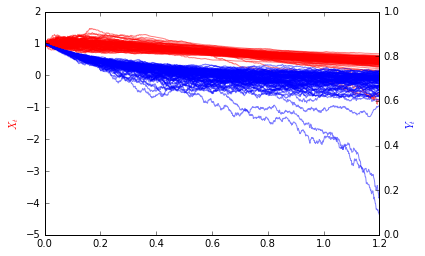

In [5]:
def mu(x, t):
    return np.asarray( [-1. * (x[0] - x[1])**2.,
                        -1. * (x[0] + x[1])**2.] )

def sigma(x, t):
    return np.asarray( [0.5 * x[0] * x[1] , 0.5 * (x[0] - x[1])] )

t0 = 0.
T = 1.2
dt = 0.001
x0 = [1., 1.]

paths, time = euler_ito_sde(mu, sigma, t0, T, dt, x0, reruns=100)

# look at paths over time
fig, ax = plt.subplots()
for path in paths:
    ax.plot(time, path[:, 0], 'r-', alpha=0.5)
    
ax2 = ax.twinx()
for path in paths:
    ax.plot(time, path[:, 1], 'b-', alpha=0.5)

ax.set_ylabel('$X_t$', color='r') 
ax2.set_ylabel('$Y_t$', color='b')
plt.xlabel('$t$')
plt.show()

I'll work on implementing some more specialized models soon. For now, there's a slightly more realistic model of security prices due to Steve Heston. Instead of treating the volatility as a constant function, as in GBM, we instead model it as a random variable:

\begin{equation}
\begin{aligned}
dX_t &= \mu(X_t, t) dt + \sigma_t X_t dW_t^{(X)} \\
d\sigma_t^2 &= \alpha(\bar{\sigma}^2 - \sigma_t^2) dt + \xi \sigma_t dW_t^{(\sigma^2)} \\
dW_t^{(\sigma^2)} &= \rho dW_t^{(X)} + \sqrt{1 - \rho^2} dZ_t,\ \rho \in [0, 1] \\
dZ_t &\sim \mathcal{N}(0, \sqrt{dt})
\end{aligned}
\end{equation}

In Heston's original model, $\mu(x, t) = \mu$, a constant. We're under no such restrictions here!

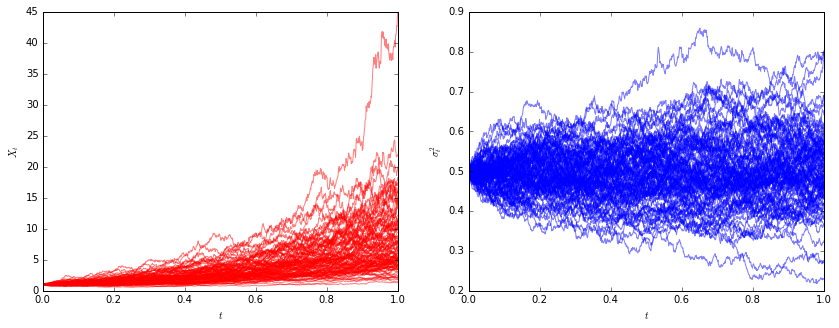

In [6]:
from stochastic_volatility import heston_model

def standard_mu(x, t):
    return 2. * x

t0 = 0.
T = 1.
dt = 0.001
x0 = [1., 0.5]  # x[0] = X, x[1] = sigma^2
sigmabar = 0.5
corr = 0.5
vol_vol = 0.2

standard_paths, time = heston_model(standard_mu, t0, T, dt, x0, 
                                   sigmabar=sigmabar, corr=corr,
                                   vol_vol=vol_vol)

# look at paths over time
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for path in standard_paths:
    axes[0].plot(time, path[:, 0], 'r-', alpha=0.5)
    axes[1].plot(time, path[:, 1], 'b-', alpha=0.5)
    
axes[0].set_xlabel('$t$')
axes[1].set_xlabel('$t$')
axes[0].set_ylabel('$X_t$')
axes[1].set_ylabel('$\sigma_t^2$')
plt.show()